# Autoencoders

## Seoul AI Meetup, July 8

Martin Kersner, <m.kersner@gmail.com>

Structure of this presentation is largely based on chapter *15: Autoencoders* from book [Hands-On Machine Learning with Scikit-Learn & Tensorflow](http://shop.oreilly.com/product/0636920052289.do).

Some examples are modified version of https://github.com/ageron/handson-ml.

In [30]:
%matplotlib inline

import numpy as np
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

### Content
1. Efficient Data Representation
1. Principal Component Analysis (PCA)
1. Stacked Autoencoders
    1. Denoising Autoencoders
    1. Sparse Autoencoders
    1. Variational Autoencoders
    1. Other Autoencoders

## Efficient Data Representation

* Number sequences
    * 56, 46, 8, 56, 7, 6, 8, 52,... 
    * 5, 16, 8, 4, 2, 1, 4, 2, 1,...

* Lower Data Dimensionality
  * Reduced computational cost
  * Easier to train ([Curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality))
  * Easier to visualize
      * *N*D -> 3D
      * *N*D -> 2D
* Other methods
    * [Factor Analysis](https://en.wikipedia.org/wiki/Factor_analysis)
    * [Independent Component Analysis](https://en.wikipedia.org/wiki/Independent_component_analysis)
    * [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding)

## Principal Component Analysis

* For unlabeled data
* Transformation from original coordinate system to the new one
* Orthogonal linear transformation
* Used for dimensionality reduction
* Principal components represent directions along which the data has the largest variations
* [sklearn.decomposition.PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html)

### [Yale Face Database](http://vision.ucsd.edu/content/yale-face-database)

* 15 people
* 11 images per subject one per different facial expression or configuration
* (center-light w/glasses, happy, left-light, w/no glasses, normal, right-light, sad, sleepy, surprised, and wink)

<img src="https://raw.githubusercontent.com/martinkersner/autoencoder-meetup/master/files/yale-faces.png" style="width: 30%; height: 30%; margin-left: auto; margin-right: auto; "/>

### Eigenfaces ([Jupyter Notebook](https://github.com/martinkersner/seoul-artificial-intelligence-meetup/blob/master/eigen-fisher-faces/eigen-faces.ipynb))

<img src="https://raw.githubusercontent.com/martinkersner/autoencoder-meetup/master/files/yale-pca.png"  style="width: 40%; height: 40%; margin-left: auto; margin-right: auto; " />

In [1]:
# scikit-learn: Principal Component Analysis
import numpy as np
from sklearn.decomposition import PCA

X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
pca = PCA(n_components=2)
pca.fit(X)

print(pca.explained_variance_ratio_)

[ 0.99244289  0.00755711]


## Autoencoders

* Artificial Neural Networks
* Same architecture as Multi-Layer Perceptron
* Number of input neurons = Number of output neurons
* Trained to efficiently encode (**codings**) input information


* Purposes
  * Decrease dimensionality
  * Feature detectors (unsupervised pretraining for deep neural networks)
  * Randomly generate new data

* **Encoder** (Recognition network)
* **Decoder** (Generative network)
 
 <center><img src="https://i.stack.imgur.com/aziW7.png" /><center>
 
 Example of **undercomplete** autoencoder.

In [31]:
# source: https://github.com/ageron/handson-ml
import numpy.random as rnd

rnd.seed(4)
m = 200
w1, w2 = 0.1, 0.3
noise = 0.1

angles = rnd.rand(m) * 3 * np.pi / 2 - 0.5
data = np.empty((m, 3))
data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * rnd.randn(m) / 2
data[:, 1] = np.sin(angles) * 0.7 + noise * rnd.randn(m) / 2
data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * rnd.randn(m)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(data[:100])
X_test = scaler.transform(data[100:])

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

def plot_coding(codings):
    fig = plt.figure(figsize=(4,3))
    plt.plot(codings[:,0], codings[:, 1], "b.")
    plt.xlabel("$z_1$", fontsize=18)
    plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.show()
    
def plot_codings(codings1, codings2):
    plt.rcParams['axes.labelsize'] = 28
    plt.figure(1, figsize=(12, 6))
    
    plt.subplot(121)
    plt.plot(codings1[:,0], codings1[:, 1], "b.")
    plt.xlabel("$z_1$", fontsize=18)
    plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.title("PCA")
    
    plt.subplot(122)
    plt.plot(codings2[:,0], codings2[:, 1], "b.")
    plt.xlabel("$z_1$", fontsize=18)
    plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.title("Autoencoder")
    
    plt.show()

def plot_many_codings(codings_lst):
    plt.rcParams['axes.labelsize'] = 20
    plt.figure(1, figsize=(20, 8))
    
    rows = 2
    cols = 5
    
    pos = 1
    for idx in range(0, len(codings_lst)):
        if pos > rows*cols:
            break
        
        codings = codings_lst[idx]
        
        plt.subplot(rows, cols, pos)
        plt.plot(codings[:,0], codings[:, 1], "b.")
        plt.xlabel("$z_1$", fontsize=14)
        plt.ylabel("$z_2$", fontsize=14, rotation=0)
        
        pos += 1
    
    plt.show()

## Autoencoder as PCA

* Linear activations
* Cost function Mean Squared Error

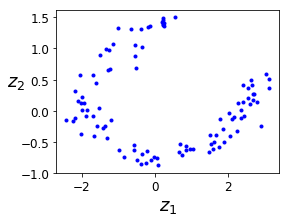

In [59]:
# PCA
pca = PCA(n_components=2)
pca.fit(X_train)
pca_codings = pca.transform(X_test)

# Encodings created using PCA
plot_coding(pca_codings)

In [108]:
# source: https://github.com/ageron/handson-ml
import tensorflow as tf

reset_graph()

n_inputs = 3
n_hidden = 2  # codings
n_outputs = n_inputs

learning_rate = 0.01

X = tf.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.layers.dense(X, n_hidden)
outputs = tf.layers.dense(hidden, n_outputs)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

init = tf.global_variables_initializer()

n_iterations = 50000
codings = hidden

codings_val_progress = []

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        training_op.run(feed_dict={X: X_train})
        if (iteration % 5000) == 0:
            codings_val_progress.append(codings.eval(feed_dict={X: X_test}))
            
    codings_val = codings.eval(feed_dict={X: X_test})

## Autoencoder Temporary Results

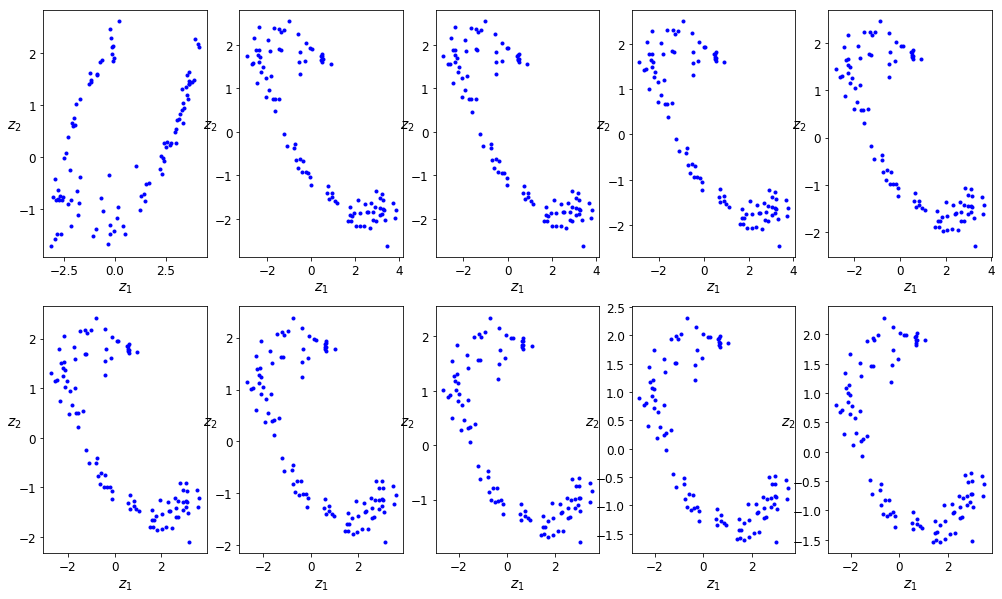

In [116]:
plot_many_codings(codings_val_progress)

## PCA vs Autoencoder

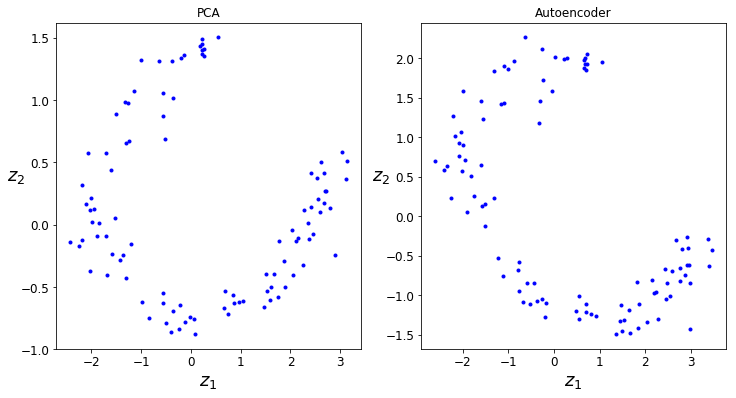

In [96]:
plot_codings(pca_codings, codings_val)

## [sklearn.preprocessing.StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)

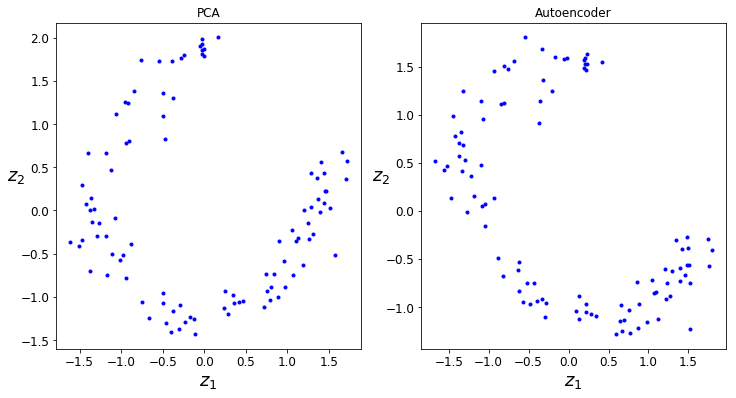

In [65]:
scaler1 = StandardScaler()
pca_norm = scaler.fit_transform(pca_codings)
scaler2 = StandardScaler()
autoencoder_norm = scaler.fit_transform(codings_val)
plot_codings(pca_norm, autoencoder_norm)

## [sklearn.preprocessing.normalize](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html)

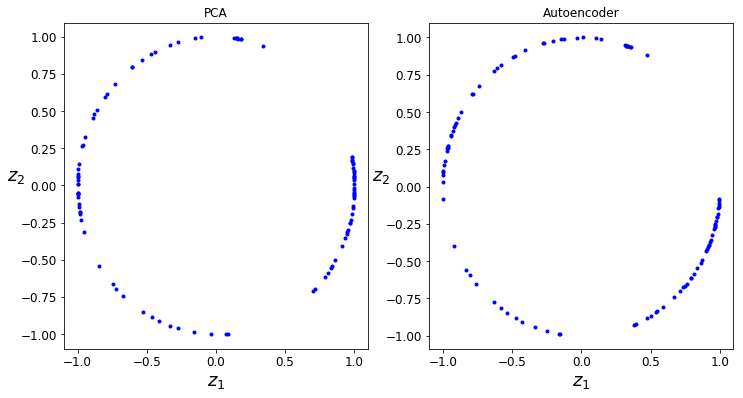

In [66]:
from sklearn.preprocessing import normalize

pca_norm = normalize(pca_codings)
autoencoder_norm = normalize(codings_val)
plot_codings(pca_norm, autoencoder_norm)

## Stacked Autoencoders

* Multiple hidden layers => Stacked Autoencoders, Deep Autoencoders
* Learn more complex codings
* Typically symmetrical architecture

<center><img src="https://inspirehep.net/record/1252540/files/autoencoder.png" /></center>

In [51]:
# source: https://github.com/ageron/handson-ml
# load MNIST
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/")

def plot_image(image, shape=[28, 28]):
    plt.imshow(image.reshape(shape), cmap="Greys", interpolation="nearest")
    plt.axis("off")

def show_reconstructed_digits(X, outputs, model_path = "./my_model_all_layers.ckpt", n_test_digits = 2):
    with tf.Session() as sess:
        if model_path:
            saver.restore(sess, model_path)
        X_test = mnist.test.images[:n_test_digits]
        outputs_val = outputs.eval(feed_dict={X: X_test})

    fig = plt.figure(figsize=(8, 3 * n_test_digits))
    for digit_index in range(n_test_digits):
        plt.subplot(n_test_digits, 2, digit_index * 2 + 1)
        plot_image(X_test[digit_index])
        plt.subplot(n_test_digits, 2, digit_index * 2 + 2)
        plot_image(outputs_val[digit_index])

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [48]:
# source: https://github.com/ageron/handson-ml
import tensorflow as tf
from functools import partial

# Build network
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

he_init = tf.contrib.layers.variance_scaling_initializer() # He initialization
#Equivalent to:
#he_init = lambda shape, dtype=tf.float32: tf.truncated_normal(shape, 0., stddev=np.sqrt(2/shape[0]))
l2_regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
my_dense_layer = partial(tf.layers.dense,
                         activation=tf.nn.elu,
                         kernel_initializer=he_init,
                         kernel_regularizer=l2_regularizer)

hidden1 = my_dense_layer(X, n_hidden1)
hidden2 = my_dense_layer(hidden1, n_hidden2)
hidden3 = my_dense_layer(hidden2, n_hidden3)
outputs = my_dense_layer(hidden3, n_outputs, activation=None)

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

reg_losses = tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)
loss = tf.add_n([reconstruction_loss] + reg_losses)

optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()
saver = tf.train.Saver() # not shown in the book

In [49]:
# source: https://github.com/ageron/handson-ml
import sys

# Training
n_epochs = 5
batch_size = 150

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        n_batches = mnist.train.num_examples // batch_size
        for iteration in range(n_batches):
            print("\r{}%".format(100 * iteration // n_batches), end="") # not shown in the book
            sys.stdout.flush()                                          # not shown
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            sess.run(training_op, feed_dict={X: X_batch})
        loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})   # not shown
        print("\r{}".format(epoch), "Train MSE:", loss_train)           # not shown
        saver.save(sess, "./my_model_all_layers.ckpt")                  # not shown
        

0 Train MSE: 0.0208356
1 Train MSE: 0.0117971
2 Train MSE: 0.0105555
3 Train MSE: 0.0102455
4 Train MSE: 0.0107827


### Tying Weights

* When layers of **Encoder** are symmetrical to **Decoder**, weights can be shared => Tying Weights
* Half of the weights
    * Speed up training
    * Limiting risk of overfitting

\begin{align}
W_{N-L+1} = W_{L}^{T} \text{ for } L = 1,2,3, ..., N/2
\end{align}

### Training One Autoencoder at a Time

* Training of shallow autoencoder is faster than training stacked autoencoders at once.
* Training is performed in phases.

<center><img src="http://i.imgur.com/MsUDBFp.png" /></center>

In [32]:
# source: https://github.com/ageron/handson-ml
reset_graph()

n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 150  # codings
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 0.01
l2_reg = 0.0001

activation = tf.nn.elu
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)
initializer = tf.contrib.layers.variance_scaling_initializer()

X = tf.placeholder(tf.float32, shape=[None, n_inputs])

weights1_init = initializer([n_inputs, n_hidden1])
weights2_init = initializer([n_hidden1, n_hidden2])
weights3_init = initializer([n_hidden2, n_hidden3])
weights4_init = initializer([n_hidden3, n_outputs])

weights1 = tf.Variable(weights1_init, dtype=tf.float32, name="weights1")
weights2 = tf.Variable(weights2_init, dtype=tf.float32, name="weights2")
weights3 = tf.Variable(weights3_init, dtype=tf.float32, name="weights3")
weights4 = tf.Variable(weights4_init, dtype=tf.float32, name="weights4")

biases1 = tf.Variable(tf.zeros(n_hidden1), name="biases1")
biases2 = tf.Variable(tf.zeros(n_hidden2), name="biases2")
biases3 = tf.Variable(tf.zeros(n_hidden3), name="biases3")
biases4 = tf.Variable(tf.zeros(n_outputs), name="biases4")

hidden1 = activation(tf.matmul(X, weights1) + biases1)
hidden2 = activation(tf.matmul(hidden1, weights2) + biases2)
hidden3 = activation(tf.matmul(hidden2, weights3) + biases3)
outputs = tf.matmul(hidden3, weights4) + biases4

reconstruction_loss = tf.reduce_mean(tf.square(outputs - X))

In [33]:
# source: https://github.com/ageron/handson-ml
optimizer = tf.train.AdamOptimizer(learning_rate)

with tf.name_scope("phase1"):
    phase1_outputs = tf.matmul(hidden1, weights4) + biases4  # bypass hidden2 and hidden3
    phase1_reconstruction_loss = tf.reduce_mean(tf.square(phase1_outputs - X))
    phase1_reg_loss = regularizer(weights1) + regularizer(weights4)
    phase1_loss = phase1_reconstruction_loss + phase1_reg_loss
    phase1_training_op = optimizer.minimize(phase1_loss)

with tf.name_scope("phase2"):
    phase2_reconstruction_loss = tf.reduce_mean(tf.square(hidden3 - hidden1))
    phase2_reg_loss = regularizer(weights2) + regularizer(weights3)
    phase2_loss = phase2_reconstruction_loss + phase2_reg_loss
    train_vars = [weights2, biases2, weights3, biases3]
    phase2_training_op = optimizer.minimize(phase2_loss, var_list=train_vars) # freeze hidden1

In [34]:
# source: https://github.com/ageron/handson-ml
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [35]:
# source: https://github.com/ageron/handson-ml
training_ops = [phase1_training_op, phase2_training_op]
reconstruction_losses = [phase1_reconstruction_loss, phase2_reconstruction_loss]
n_epochs = [4, 4]
batch_sizes = [150, 150]

with tf.Session() as sess:
    init.run()
    for phase in range(2):
        print("Training phase #{}".format(phase + 1))
        for epoch in range(n_epochs[phase]):
            n_batches = mnist.train.num_examples // batch_sizes[phase]
            for iteration in range(n_batches):
                print("\r{}%".format(100 * iteration // n_batches), end="")
                sys.stdout.flush()
                X_batch, y_batch = mnist.train.next_batch(batch_sizes[phase])
                sess.run(training_ops[phase], feed_dict={X: X_batch})
            loss_train = reconstruction_losses[phase].eval(feed_dict={X: X_batch})
            print("\r{}".format(epoch), "Train MSE:", loss_train)
            saver.save(sess, "./my_model_one_at_a_time.ckpt")
    loss_test = reconstruction_loss.eval(feed_dict={X: mnist.test.images})
    print("Test MSE:", loss_test)

Training phase #1
0 Train MSE: 0.00724277
1 Train MSE: 0.007386
2 Train MSE: 0.00773445
3 Train MSE: 0.0075949
Training phase #2
0 Train MSE: 0.0652317
1 Train MSE: 0.00354873
2 Train MSE: 0.00212835
3 Train MSE: 0.00197275
Test MSE: 0.00970625


### Visualizing the Reconstructions

INFO:tensorflow:Restoring parameters from ./my_model_all_layers.ckpt


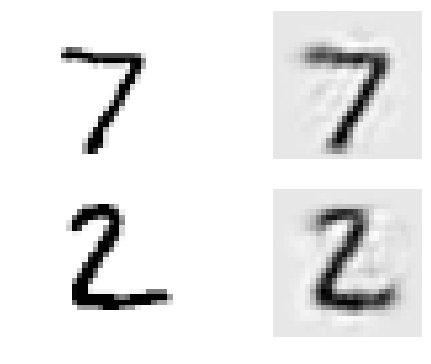

In [52]:
show_reconstructed_digits(X, outputs)

### Techniques of Visualizing Features

1. Examine each neuron in every layer independently
1. Display weights of each neuron in the first layer

In [37]:
# source: https://github.com/ageron/handson-ml
with tf.Session() as sess:
    saver.restore(sess, "./my_model_one_at_a_time.ckpt")
    weights1_val = weights1.eval()

INFO:tensorflow:Restoring parameters from ./my_model_one_at_a_time.ckpt


In [44]:
def plot_features_from_first_hidden_layer(weights):
    plt.figure(1, figsize=(24, 12))
    
    for i in range(10):
        plt.subplot(1, 10, i + 1)
        plot_image(weights.T[i])

    plt.show()

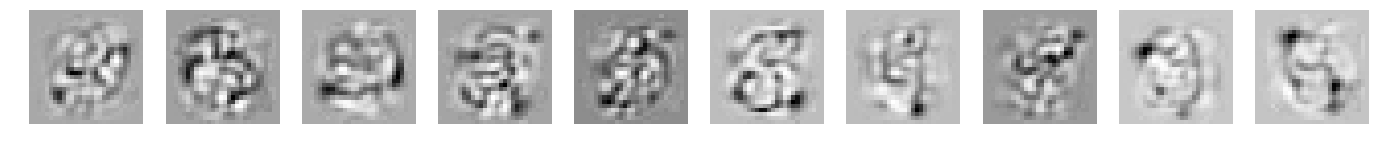

In [45]:
plot_features_from_first_hidden_layer(weights1_val)

## Unsupervised Pretraining Using Stacked Autoencoders

1. Train autoencoder
1. Freeze Encoder weights
1. Remove Decoder
1. Train classifier on top of network

<center><img src="http://i.imgur.com/GnfiS7O.png" /></center>

## Denoising Autoencoders

## Sparse Autoencoders

* Loss function involves **sparsity penalty** on the code layer.
* Used to learn features for another task such as classification.

\begin{align}
L(\boldsymbol{x}, g(f(\boldsymbol{x}))) + \Omega(\boldsymbol{h}), \text{ where } \boldsymbol{h} = f(\boldsymbol{x})
\end{align}

## Variational Autoencoders